# Importing and installing Libraries

In [1]:
!pip install keras-tuner --upgrade
!pip install pydicom

     |████████████████████████████████| 97 kB 3.3 MB/s 
     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [2]:
import keras_tuner as kt

import os
import glob

import pandas as pd
import numpy as np
from pathlib import Path

import random
from tqdm.notebook import tqdm
import pydicom # Handle MRI images

import cv2  # OpenCV - https://docs.opencv.org/master/d6/d00/tutorial_py_root.html

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading and Converting Data in 2D image classification format 

In [4]:
!cp "/content/drive/MyDrive/kaggle_competitions/RSNA_MICCAI_Brain_Tumor_Radiogenomic_Classification/results.zip" "/content/"

In [5]:
!unzip results.zip

Archive:  results.zip
  inflating: 224_FLAIR_test_X.npy    
  inflating: 224_FLAIR_test_id.npy   
  inflating: 224_FLAIR_train_X.npy   
  inflating: 224_FLAIR_train_id.npy  
  inflating: 224_FLAIR_train_y.npy   
  inflating: 224_T1wCE_test_X.npy    
  inflating: 224_T1wCE_test_id.npy   
  inflating: 224_T1wCE_train_X.npy   
  inflating: 224_T1wCE_train_id.npy  
  inflating: 224_T1wCE_train_y.npy   


In [6]:
X_temp = np.load('/content/224_FLAIR_train_X.npy',allow_pickle=True)
y_temp = np.load('/content/224_FLAIR_train_y.npy', allow_pickle=True)
trainidt = np.load('/content/224_FLAIR_train_id.npy', allow_pickle=True)

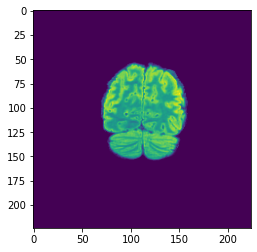

In [7]:
plt.imshow(X_temp[0][100])

In [8]:
X_test_temp= np.load('/content/224_FLAIR_test_X.npy',allow_pickle=True)
testidt = np.load('/content/224_FLAIR_test_id.npy', allow_pickle=True)

In [9]:
len(X_temp), len(X_temp[0]), (X_temp[0][0]).shape

(582, 400, (224, 224))

Note - The format of data after loading is  [ [Dicom of paitent 1: img1, img2, img3 --- ]]</br>
ie. list of patients, and the list of images of individual patient and each images of shape (224,224)  

#### Below code will convert it to (image, labels, ids) pair so that we can feed it directly into image classification model

In [10]:
# Create 1 channel imahges 

# Convert 

X= []
y = []
train_id = []

for i, im in enumerate(X_temp):
    num_images = len(im)
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    interval = 3
    if num_images < 10: 
        interval = 1
    im_current = im[start:end:interval]
    X+= im_current 
    y += [y_temp[i]] * len(im_current)

    train_id += [trainidt[i]]*len(im_current)

In [11]:
len(X), len(y), len(train_id)

(12463, 12463, 12463)

In [12]:
# Converting all lists into array
X= np.array(X)
y = np.array(y)
train_id = np.array(train_id)

In [14]:
X.shape

(12463, 224, 224)

In [15]:
# Same for test

In [16]:
X_test= []
test_id = []

for i, im in enumerate(X_test_temp):
    num_images = len(im)
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    interval = 3
    if num_images < 10: 
        interval = 1
    im_current = im[start:end:interval]
    X_test+= im_current
    test_id += [testidt[i]]*len(im_current)

In [17]:

len(X_test), len(test_id)

(1822, 1822)

In [24]:
X_train, X_valid, y_train, y_valid, trainidt_train, trainidt_valid = train_test_split(X, y, train_id, test_size=0.2, random_state=42)

In [26]:
# Convert y to one hot encoded y
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [27]:
# Expand dims of X_train, and X_Valid from (224, 224) -> (224, 224, 1)
X_train = tf.expand_dims(X_train, axis =3)
X_valid = tf.expand_dims(X_valid, axis =3)
X_train.shape, X_valid.shape

(TensorShape([9970, 224, 224, 1]), TensorShape([2493, 224, 224, 1]))

# Create Model (use Keras Tuner)

In [28]:
import keras_tuner as kt


def make_model(hp):
  # Input of model
    inputs = keras.Input(shape=X_train.shape[1:])
  
  # Rescaling the model by dividing 255.0
    x = keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)

  # Adding layer and keras hyperparameter search space 
    x = keras.layers.Conv2D(filters=hp.Int('units_Conv_1_' + str(0),
                                            min_value=64,
                                            max_value=256,
                                            step=32),
                            kernel_size=hp.Choice('convolution_1', values = [2,4]),
                            activation="relu", 
                            name="Conv_1")(x)
  # Maxpool
    x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

  # Adding layer and keras hyperparameter search space 
    x = keras.layers.Conv2D(filters=hp.Int('units_conv2_' + str(1),
                                            min_value=16,
                                            max_value=128,
                                            step=16),
                            kernel_size=hp.Choice('convolution_2', values = [2,4]),
                            activation="relu",
                            name="Conv_2")(x)

  # Maxpool
    x = keras.layers.MaxPool2D(pool_size=(1, 1))(x)
  
  # Dropout 
    x = layers.Dropout(
        hp.Float('dense_dropout', min_value=0., max_value=0.7)
    )(x)
  # Flatten
    x = keras.layers.Flatten()(x)

  # Dense (hidden layer)
    x = layers.Dense(
        units=hp.Int('num_dense_units', min_value=16, max_value=64, step=8),
        activation='relu'
    )(x)

  # Output layer as y hot encoded so we used 2 
    outputs = keras.layers.Dense(2, activation="softmax")(x)

  # Creating model
    model = keras.Model(inputs, outputs)

  # Defining AUC metrics 
    roc_auc = tf.keras.metrics.AUC(name='roc_auc', curve='ROC')

  # Compile the model
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=[roc_auc]
    )
    model.summary()
    return model

In [29]:
# Create rtuner object for Baysian optimization 
tuner = kt.tuners.BayesianOptimization(
      make_model,
      objective='val_loss',
      seed = 42,
      max_trials=5,  # Set to 5 to run quicker, but need 100+ for good results
      directory="model", # This should be set if you want to resume if stopped unexpected 
      project_name = "224_FLAIR")

callbacks=[keras.callbacks.EarlyStopping(monitor='val_roc_auc', mode='max', patience=5, baseline=0.9)]

# Start searching the best parameters 
tuner.search(X_train, y_train, validation_split=0.2, callbacks=callbacks, verbose=1, epochs=20)

Trial 5 Complete [00h 02m 55s]
val_loss: 0.5520935654640198

Best val_loss So Far: 0.49550771713256836
Total elapsed time: 00h 12m 17s
INFO:tensorflow:Oracle triggered exit


# After full search initiate the model with best parameter 

In [30]:
best_hp = tuner.get_best_hyperparameters()[0]

In [31]:
best_hp.get_config()

{'space': [{'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 256,
    'min_value': 64,
    'name': 'units_Conv_1_0',
    'sampling': None,
    'step': 32}},
  {'class_name': 'Choice',
   'config': {'conditions': [],
    'default': 2,
    'name': 'convolution_1',
    'ordered': True,
    'values': [2, 4]}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 128,
    'min_value': 16,
    'name': 'units_conv2_1',
    'sampling': None,
    'step': 16}},
  {'class_name': 'Choice',
   'config': {'conditions': [],
    'default': 2,
    'name': 'convolution_2',
    'ordered': True,
    'values': [2, 4]}},
  {'class_name': 'Float',
   'config': {'conditions': [],
    'default': 0.0,
    'max_value': 0.7,
    'min_value': 0.0,
    'name': 'dense_dropout',
    'sampling': None,
    'step': None}},
  {'class_name': 'Int',
   'config': {'conditions': [],
    'default': None,
    'max_value': 64,
    'min_value': 16

In [32]:
best_model = make_model(best_hp)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 1)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 223, 223, 192)     960       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 192)     0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 108, 108, 64)      196672    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 108, 108, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 108, 108, 64)      0   

# Fit for longer duration

In [33]:
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=50)

Epoch 1/50
250/250 [==============================] - 27s 103ms/step - loss: 0.6783 - roc_auc: 0.6341 - val_loss: 0.6512 - val_roc_auc: 0.6636
Epoch 2/50
250/250 [==============================] - 26s 102ms/step - loss: 0.6231 - roc_auc: 0.7101 - val_loss: 0.6181 - val_roc_auc: 0.7166
Epoch 3/50
250/250 [==============================] - 25s 102ms/step - loss: 0.5579 - roc_auc: 0.7849 - val_loss: 0.5799 - val_roc_auc: 0.7616
Epoch 4/50
250/250 [==============================] - 26s 102ms/step - loss: 0.4870 - roc_auc: 0.8459 - val_loss: 0.5640 - val_roc_auc: 0.7882
Epoch 5/50
250/250 [==============================] - 25s 101ms/step - loss: 0.4224 - roc_auc: 0.8884 - val_loss: 0.5413 - val_roc_auc: 0.8103
Epoch 6/50
250/250 [==============================] - 25s 101ms/step - loss: 0.3562 - roc_auc: 0.9225 - val_loss: 0.5091 - val_roc_auc: 0.8398
Epoch 7/50
250/250 [==============================] - 25s 102ms/step - loss: 0.2969 - roc_auc: 0.9461 - val_loss: 0.5189 - val_roc_auc: 0.8517

# save the model 

In [34]:
best_model.save("final.h5")